# Multimodal Brain Tumor Segmentation
---

## **1. Introduction**
Brain tumor segmentation is a crucial step in medical imaging analysis, aiding in diagnosis and treatment planning. This project implements a model for brain tumor segmentation using **four MRI modalities**: T1, T1ce, T2, and FLAIR. Two feature fusion strategies are explored:

1. **Input-Level Fusion**: All modalities are stacked as a Single 4-channel input.
2. **Feature-Input Fusion**: Merging all the modalities in the model architecture.

This approach is inspired by the **BraTS dataset** and leverages **deep learning** for robust segmentation.


## **2. Dataset Description**
The dataset used in this implementation is derived from **BraTS 2020**, which contains:

- **Four MRI modalities**: T1, T1ce, T2, and FLAIR.
- **Segmentation Masks**: The ground truth labels include four classes:
  - 0: Background (Non-tumor region)
  - 1: Necrotic Core
  - 2: Edema
  - 3: Enhancing Tumor

The MRI scans are provided in **NIfTI (.nii.gz) format**, which is preprocessed before training.


## **3. Data Preprocessing**
### **3.1 Skull Stripping**
To remove non-brain regions, a skull-stripping technique is applied using:
- **Otsu’s thresholding**
- **Morphological operations** (Closing & Opening)
- **Masking the original image**

### **3.2 Data Normalization**
To ensure uniform intensity across different modalities, specific normalization methods are tested:

### **3.3 Data Augmentation**
- **Random slice selection** from 3D volumes
- **Rotation and flipping**
- **Resizing** images to `128x128`

### **3.4 Data Generator**
A **custom Keras Data Generator** is implemented to:
- Load slices on-the-fly (memory-efficient)
- Handle **early and late fusion** formats
- Apply **one-hot encoding** to segmentation masks


## **4. Model Architecture**
- All four modalities are stacked into a  **Single 4-channel input**.
- Standard **encoder-decoder** structure.
- Feature maps from different modalities are **merged in the bottleneck**.
- Final layer uses a **1x1 convolution with Softmax activation** for segmentation.

## **5. Training Strategy**
### **5.1 Loss Function**
- **Categorical Crossentropy Loss** (for multi-class segmentation)
- **Dice Coefficient** (as an evaluation metric)

### **5.2 Optimizer & Learning Rate Scheduling**
- **Adam Optimizer** with an initial learning rate of `0.0001`
- **ReduceLROnPlateau** callback to lower the learning rate when validation loss plateaus

### **5.3 Training Configuration**
- **Batch size**: 8
- **Epochs**: 20
- **Train/Validation Split**: 80% / 20%
- **Model Checkpoints** to save the best-performing model

---

## **6. Model Evaluation**
After training, the models are evaluated on unseen MRI scans using:
- **Dice Score per tumor class**
- **Precision, Sensitivity, and Specificity**
- **Loss and Accuracy curves** for comparison between early and late fusion approaches

# Setup env

In [2]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  


# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
!pip install git+https://github.com/miykael/gif_your_nifti # nifti to gif 
import gif_your_nifti.core as gif2nif


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

  Cloning https://github.com/miykael/gif_your_nifti to /tmp/pip-req-build-zbuw_jnu
  Running command git clone -q https://github.com/miykael/gif_your_nifti /tmp/pip-req-build-zbuw_jnu
  Created wheel for gif-your-nifti: filename=gif_your_nifti-0.2.2-py3-none-any.whl size=6634 sha256=d95a2807e2dec777bc86348ed28cc074b9e951670e2d91e67d6e2685a5fd1f04
  Stored in directory: /tmp/pip-ephem-wheel-cache-j_2ewm48/wheels/4a/8c/d1/b228c3b67231f7459e8f70d73f4dadaf65cd90692d41f43e88
Successfully built gif-your-nifti
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include

# Dataset Loading

In [4]:
TRAIN_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()

# EDA

Text(0.5, 1.0, 'Mask')

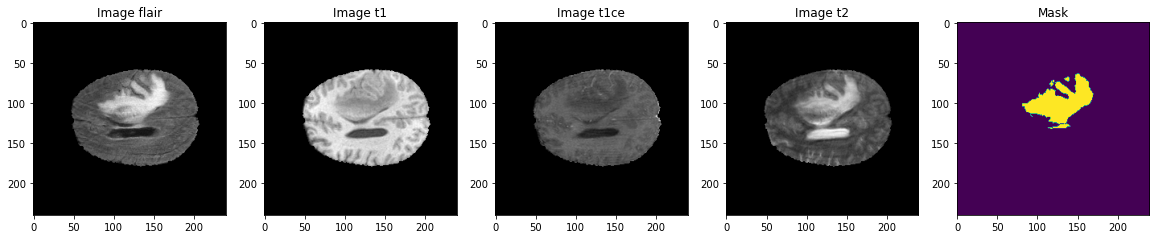

In [5]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

**Show whole nifti data -> print each slice from 3d data**

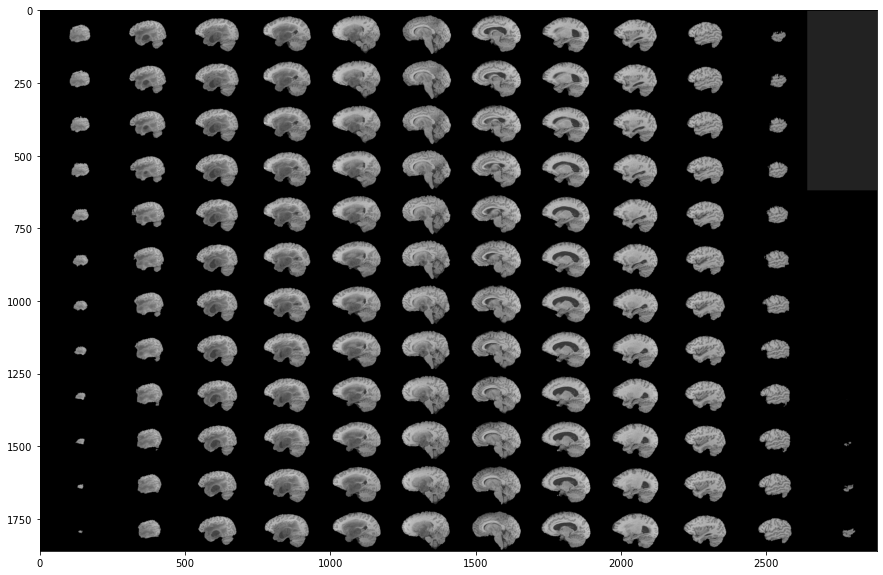

In [6]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

**Show segment of tumor for each above slice**

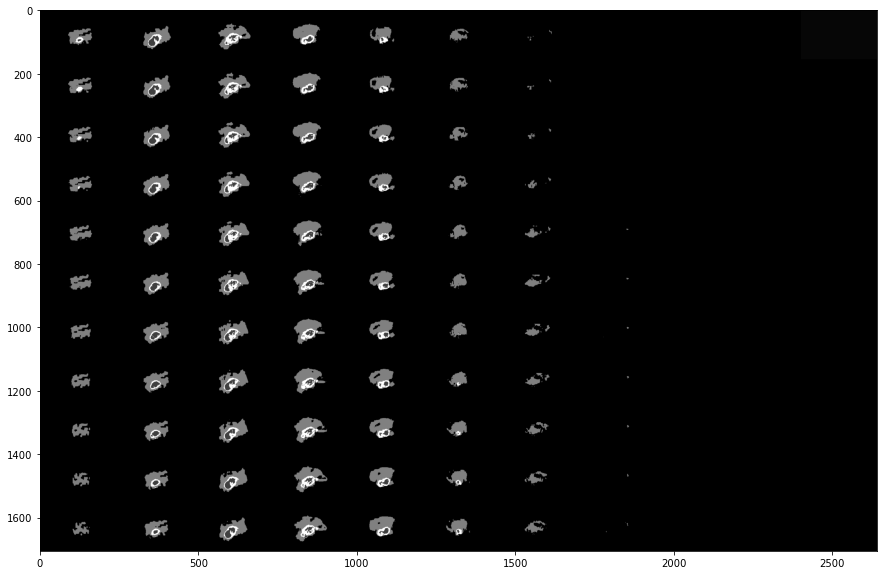

In [7]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_mask[60:-60,:,:]), 90, resize=True), cmap ='gray')

In [8]:
shutil.copy2(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii', './test_gif_BraTS20_Training_001_flair.nii')
gif2nif.write_gif_normal('./test_gif_BraTS20_Training_001_flair.nii')

**Gif representation of slices in 3D volume**
<img src="https://media1.tenor.com/images/15427ffc1399afc3334f12fd27549a95/tenor.gif?itemid=20554734">

**Show segments of tumor using different effects**

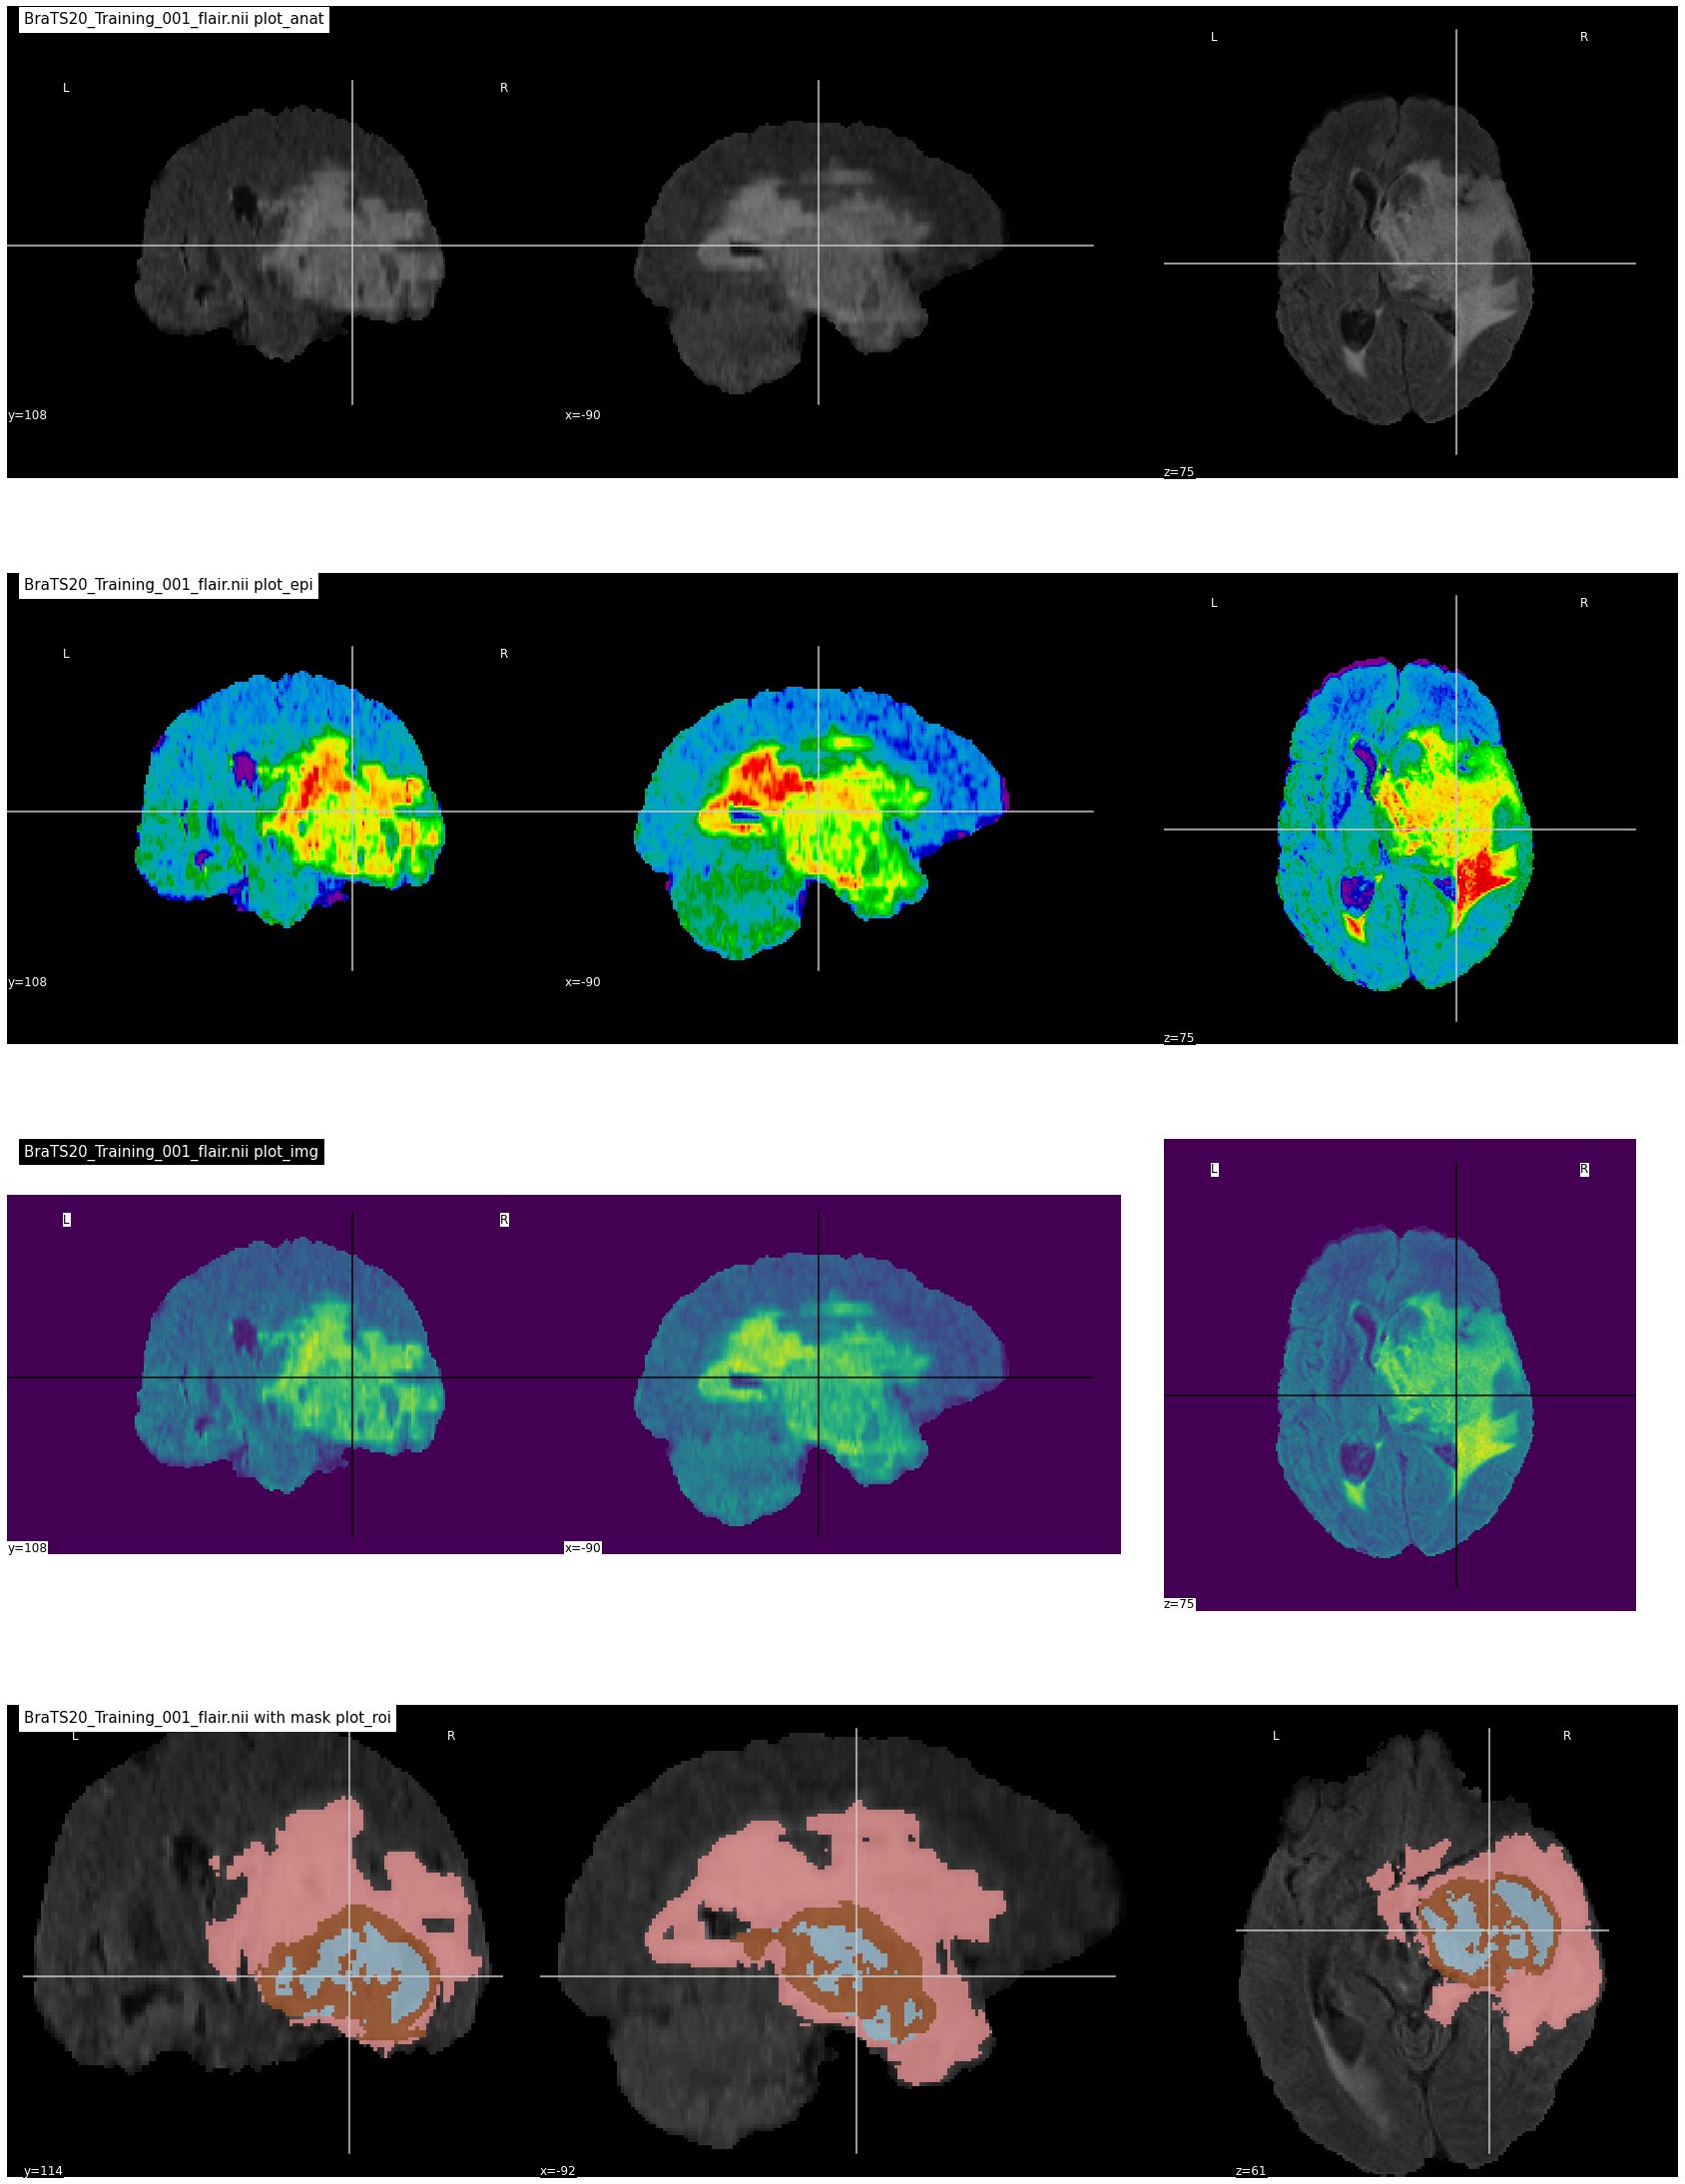

In [9]:
niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='BraTS20_Training_001_flair.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS20_Training_001_flair.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS20_Training_001_flair.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask, 
               title='BraTS20_Training_001_flair.nii with mask plot_roi',
               bg_img=niimg, 
               axes=axes[3], cmap='Paired')

plt.show()

# Data Preprocessing

## Skull Stripping and Normalization

Skull-stripped image saved at: BraTS20_Training_001_flair_skull_stripped.nii.gz


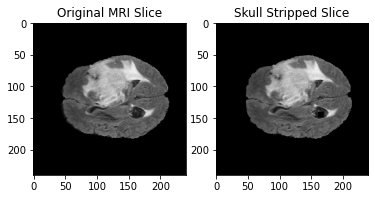

In [10]:
import numpy as np
import nibabel as nib
import cv2
import matplotlib.pyplot as plt

def skull_strip(nifti_path, output_path, slice_index=None):
    """
    Perform skull stripping on an MRI scan using OpenCV and save the processed image.
    
    Parameters:
        nifti_path (str): Path to the input NIfTI file (.nii.gz).
        output_path (str): Path to save the skull-stripped NIfTI file.
        slice_index (int, optional): Specific slice to visualize. Default is None.
    
    Returns:
        None
    """
    # Load the NIfTI image
    img_nifti = nib.load(nifti_path)
    img_data = img_nifti.get_fdata()

    # Process all slices
    stripped_slices = np.zeros_like(img_data)

    for i in range(img_data.shape[2]):  # Iterate over slices
        slice_img = img_data[:, :, i]  # Extract a single slice

        # Normalize the image (0-255)
        slice_norm = cv2.normalize(slice_img, None, 0, 255, cv2.NORM_MINMAX)
        slice_norm = np.uint8(slice_norm)

        # Apply Otsu's thresholding to create a binary mask
        _, mask = cv2.threshold(slice_norm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Perform morphological operations to remove small regions
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)

        # Apply the mask to the original image
        brain_only = cv2.bitwise_and(slice_norm, slice_norm, mask=mask)
        stripped_slices[:, :, i] = brain_only  # Store processed slice

    # Save the skull-stripped image as a NIfTI file
    stripped_nifti = nib.Nifti1Image(stripped_slices, img_nifti.affine, img_nifti.header)
    nib.save(stripped_nifti, output_path)
    print(f"Skull-stripped image saved at: {output_path}")

    # Optional: Visualize a specific slice
    if slice_index is not None:
        plt.subplot(1, 2, 1)
        plt.imshow(img_data[:, :, slice_index], cmap="gray")
        plt.title("Original MRI Slice")

        plt.subplot(1, 2, 2)
        plt.imshow(stripped_slices[:, :, slice_index], cmap="gray")
        plt.title("Skull Stripped Slice")
        plt.show()

# Example Usage
nifti_path = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii"
output_path = "BraTS20_Training_001_flair_skull_stripped.nii.gz"
skull_strip(nifti_path, output_path, slice_index=75)  # Visualize slice 75

As the dataset images are alreaday preprocessed with the main focused, so no need skull stripping

# Training Strategy

## 📌 Function: `dice_coef(y_true, y_pred, smooth=1.0)`

### 📌 Purpose:
Measures the overlap between predicted and ground truth masks. The Dice coefficient is a widely used metric in image segmentation tasks, especially in medical imaging.

In [11]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss


## 2️⃣ Dice Coefficient for Specific Tumor Classes  

The implementation computes Dice scores separately for different tumor types:  

📌 **Necrotic Tumor Core** (`dice_coef_necrotic`)  
📌 **Edema** (`dice_coef_edema`)  
📌 **Enhancing Tumor** (`dice_coef_enhancing`)  

In [12]:
# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)

## 3️⃣ Precision  

📌 **Function:** `precision(y_true, y_pred)`  
📌 **Purpose:** Measures how many predicted positive pixels are actually correct.  


- **TP (True Positives):** Correctly identified tumor pixels.  
- **FP (False Positives):** Pixels wrongly predicted as tumors.

✔ Why use clip(y_true * y_pred, 0, 1)?
🔹 Ensures values remain between 0 and 1, preventing unwanted behavior.

✔ Why is precision important?
🔹 A high precision means the model does not misclassify non-tumor areas as tumors (low false positives).

In [13]:
# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

## 4️⃣ Sensitivity (Recall)  

📌 **Function:** `sensitivity(y_true, y_pred)`  
📌 **Purpose:** Measures how many actual tumor pixels were correctly predicted.  
 
- **TP (True Positives):** Correctly identified tumor pixels.  
- **FN (False Negatives):** Pixels that should have been detected as tumors but were missed.  

✔ **Why is sensitivity important?**  
🔹 High sensitivity ensures the model doesn’t miss any tumor areas.  


In [14]:
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

## 5️⃣ Specificity  

📌 **Function:** `specificity(y_true, y_pred)`  
📌 **Purpose:** Measures how many non-tumor pixels were correctly identified.  


- **TN (True Negatives):** Correctly identified non-tumor pixels.  
- **FP (False Positives):** Pixels wrongly predicted as tumors.  

✔ **Why is specificity important?**  
🔹 Ensures the model does not mistakenly classify healthy brain tissue as tumors.  


In [15]:
# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [16]:
IMG_SIZE=128
# IMG_SIZE=224

# Feeding all the modalities data

In [17]:
import os
import nibabel as nib

# Define the path to the seg.nii file
seg_path = os.path.join(TRAIN_DATASET_PATH, "BraTS20_Training_355", "seg.nii")

# Check if the file exists
if not os.path.exists(seg_path):
    print(f"Error: seg.nii not found in {seg_path}")
else:
    try:
        # Try loading the file using nibabel
        nii_image = nib.load(seg_path)
        
        # Check basic properties
        print("seg.nii loaded successfully!")
        print(f"Image shape: {nii_image.shape}")
        print(f"Data type: {nii_image.get_data_dtype()}")

    except Exception as e:
        print(f"Error: seg.nii file is ill-formatted! {e}")

Error: seg.nii not found in ../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/seg.nii


In [18]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# file BraTS20_Training_355 has ill formatted name for for seg.nii file
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

# Data Augmentation using GAN

In [19]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 4, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))

        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t1.nii');
            t_1 = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t2.nii');
            t_2 = nib.load(data_path).get_fdata()
        
            
            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()

# Input Level Fusion
            
            # The model is combining all four modalities (Flair, T1ce, T1, and T2) in the input layer.
            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,2] = cv2.resize(t_1[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,3] = cv2.resize(t_2[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                
                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
                    
        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y
        
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

# Model Architecture

In [20]:
def custom_cnn(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)

# 4 channels for 4 modalities
# The model's first layer is designed to take a 4-channel input, which corresponds to these four modalities.
# The model is indeed combining all four modalities into a single input tensor. Each modality is processed in parallel in the same input layer, and the network learns to extract features from each modality to make predictions.

input_layer = Input((IMG_SIZE, IMG_SIZE, 4))

model = custom_cnn(input_layer, 'he_normal', 0.2)
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 1184        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

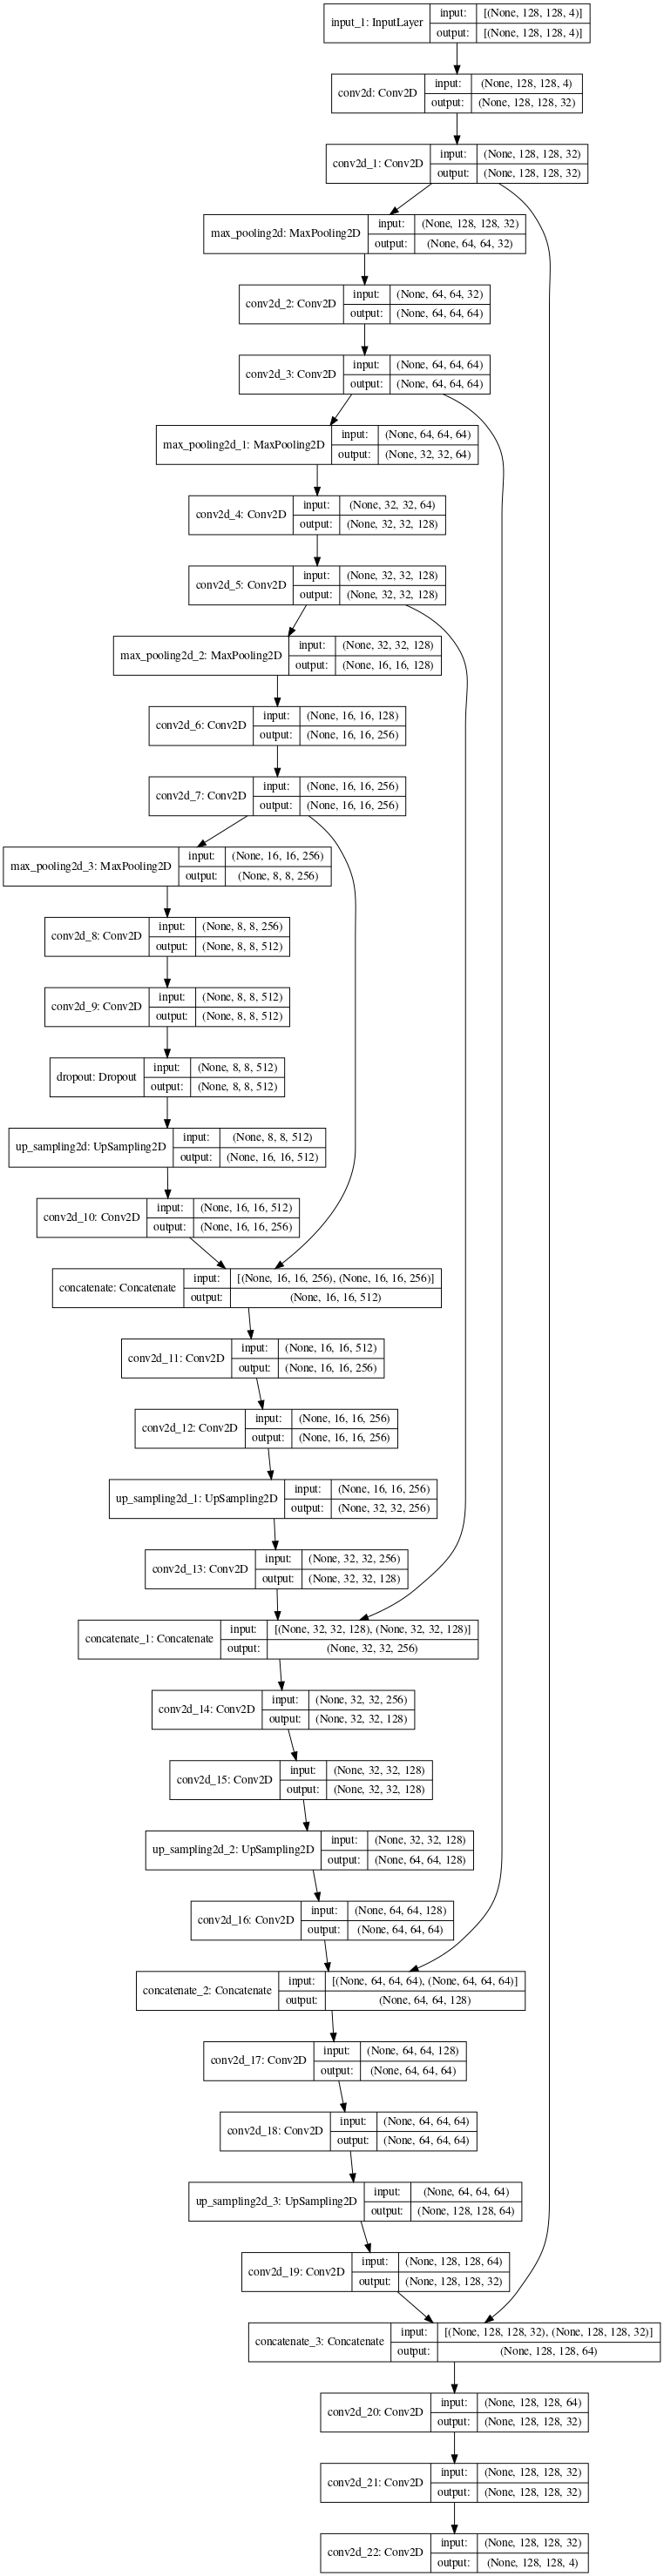

In [22]:
plot_model(model, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)

In [23]:
csv_logger = CSVLogger('training.log', separator=',', append=False)


callbacks = [
#     keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
#                               patience=2, verbose=1, mode='auto'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
#  keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
#                             verbose=1, save_best_only=True, save_weights_only = True)
        csv_logger
    ]

# Train model

In [ ]:
K.clear_session()
history =  model.fit(training_generator,
                    epochs=50,
                     steps_per_epoch=len(train_ids),
                     callbacks= callbacks,
                     validation_data = valid_generator
                     )  
model.save("Brain_tumor_segmentation.h5")

Epoch 1/50
249/249 [==============================] - 439s 2s/step - loss: 0.3591 - accuracy: 0.9436 - mean_io_u: 0.4841 - dice_coef: 0.2399 - precision: 0.9420 - sensitivity: 0.8372 - specificity: 0.9949 - dice_coef_necrotic: 0.0392 - dice_coef_edema: 0.0792 - dice_coef_enhancing: 0.0260 - val_loss: 0.0629 - val_accuracy: 0.9833 - val_mean_io_u: 0.7659 - val_dice_coef: 0.2848 - val_precision: 0.9834 - val_sensitivity: 0.9832 - val_specificity: 0.9945 - val_dice_coef_necrotic: 0.1014 - val_dice_coef_edema: 0.1481 - val_dice_coef_enhancing: 0.0812
Epoch 2/50
249/249 [==============================] - 289s 1s/step - loss: 0.0643 - accuracy: 0.9826 - mean_io_u: 0.7332 - dice_coef: 0.3046 - precision: 0.9866 - sensitivity: 0.9805 - specificity: 0.9955 - dice_coef_necrotic: 0.1708 - dice_coef_edema: 0.1787 - dice_coef_enhancing: 0.1362 - val_loss: 0.0758 - val_accuracy: 0.9833 - val_mean_io_u: 0.6333 - val_dice_coef: 0.2839 - val_precision: 0.9849 - val_sensitivity: 0.9833 - val_specificity

# Visualizing the Model Training  and Accuracy

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Load trained model
model = keras.models.load_model('/kaggle/working/Brain_tumor_segmentation.h5', 
                                custom_objects={ 'accuracy': tf.keras.metrics.MeanIoU(num_classes=4),
                                                 "dice_coef": dice_coef,
                                                 "precision": precision,
                                                 "sensitivity": sensitivity,
                                                 "specificity": specificity,
                                                 "dice_coef_necrotic": dice_coef_necrotic,
                                                 "dice_coef_edema": dice_coef_edema,
                                                 "dice_coef_enhancing": dice_coef_enhancing
                                               }, 
                                compile=False)

# Load training history
history = pd.read_csv('/kaggle/working/training.log', sep=',', engine='python')

# Ensure expected columns exist
expected_columns = ['accuracy', 'val_accuracy', 'loss', 'val_loss', 'dice_coef', 'val_dice_coef', 'mean_io_u', 'val_mean_io_u']
missing_cols = [col for col in expected_columns if col not in history.columns]

if missing_cols:
    print(f"Warning: Missing columns in history file: {missing_cols}")

# Extract training statistics
epoch = range(len(history))

acc = history.get('accuracy', None)
val_acc = history.get('val_accuracy', None)

loss = history.get('loss', None)
val_loss = history.get('val_loss', None)

train_dice = history.get('dice_coef', None)
val_dice = history.get('val_dice_coef', None)

train_iou = history.get('mean_io_u', None)
val_iou = history.get('val_mean_io_u', None)

# Plot the results
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

# Plot Accuracy
ax[0, 0].plot(epoch, acc, 'b', label='Training Accuracy')
ax[0, 0].plot(epoch, val_acc, 'r', label='Validation Accuracy')
ax[0, 0].set_title('Accuracy')
ax[0, 0].set_xlabel('Epochs')
ax[0, 0].set_ylabel('Accuracy')
ax[0, 0].legend()

# Plot Loss
ax[0, 1].plot(epoch, loss, 'b', label='Training Loss')
ax[0, 1].plot(epoch, val_loss, 'r', label='Validation Loss')
ax[0, 1].set_title('Loss')
ax[0, 1].set_xlabel('Epochs')
ax[0, 1].set_ylabel('Loss')
ax[0, 1].legend()

# Plot Dice Coefficient
ax[1, 0].plot(epoch, train_dice, 'b', label='Training Dice Coefficient')
ax[1, 0].plot(epoch, val_dice, 'r', label='Validation Dice Coefficient')
ax[1, 0].set_title('Dice Coefficient')
ax[1, 0].set_xlabel('Epochs')
ax[1, 0].set_ylabel('Dice Coefficient')
ax[1, 0].legend()

# Plot Mean IoU
ax[1, 1].plot(epoch, train_iou, 'b', label='Training Mean IoU')
ax[1, 1].plot(epoch, val_iou, 'r', label='Validation Mean IoU')
ax[1, 1].set_title('Mean IoU')
ax[1, 1].set_xlabel('Epochs')
ax[1, 1].set_ylabel('IoU Score')
ax[1, 1].legend()

# Show the plots
plt.tight_layout()
plt.show()

# Print final scores for better readability
print(f"Final Scores:")
print(f"  - Training Accuracy: {acc.iloc[-1]:.4f}, Validation Accuracy: {val_acc.iloc[-1]:.4f}")
print(f"  - Training Loss: {loss.iloc[-1]:.4f}, Validation Loss: {val_loss.iloc[-1]:.4f}")
print(f"  - Training Dice Coeff: {train_dice.iloc[-1]:.4f}, Validation Dice Coeff: {val_dice.iloc[-1]:.4f}")
print(f"  - Training Mean IoU: {train_iou.iloc[-1]:.4f}, Validation Mean IoU: {val_iou.iloc[-1]:.4f}")

# Validating the Model

In [ ]:
import tensorflow as tf
import numpy as np
import nibabel as nib
import cv2

# Load the saved model
model = tf.keras.models.load_model("Brain_tumor_segmentation.h5", custom_objects={
    'dice_coef': dice_coef,
    'precision': precision,
    'sensitivity': sensitivity,
    'specificity': specificity,
    'dice_coef_necrotic': dice_coef_necrotic,
    'dice_coef_edema': dice_coef_edema,
    'dice_coef_enhancing': dice_coef_enhancing
})

def preprocess_image(image_file, slice_index=None):
    # Load the NIfTI file
    img = nib.load(image_file).get_fdata()
    
    # Select a specific slice if needed
    if slice_index is not None:
        img = img[:, :, slice_index]
    
    # Resize the image to (IMG_SIZE, IMG_SIZE)
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    
    # Normalize the image
    img_resized = img_resized / np.max(img_resized)
    
    return img_resized

def predict(image_paths, slice_index):
    X = np.zeros((1, IMG_SIZE, IMG_SIZE, 4))
    
    # Process specific slices from the images
    X[0, :, :, 0] = preprocess_image(image_paths[0], slice_index)
    X[0, :, :, 1] = preprocess_image(image_paths[1], slice_index)
    X[0, :, :, 2] = preprocess_image(image_paths[2], slice_index)
    X[0, :, :, 3] = preprocess_image(image_paths[3], slice_index)
    
    # Make prediction
    pred = model.predict(X)
    
    return np.argmax(pred[0], axis=-1)

In [ ]:
# Example usage
image_paths = [
    '/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_010/BraTS20_Validation_010_flair.nii',
    '/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_010/BraTS20_Validation_010_t1ce.nii',
    '/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_010/BraTS20_Validation_010_t1.nii',
    '/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_010/BraTS20_Validation_010_t2.nii'
]

slice_index = 75  # Example slice index
prediction = predict(image_paths, slice_index)

In [ ]:
import numpy as np

def get_classification(pred):
    # Get the class with the highest probability for each pixel
    class_predictions = np.argmax(pred, axis=-1)
    return class_predictions


In [ ]:
get_classification(prediction)

In [ ]:
import matplotlib.pyplot as plt

def visualize_prediction(prediction):
    plt.imshow(prediction, cmap='nipy_spectral')  # 'nipy_spectral' gives distinct colors for different classes
    plt.title('Predicted Segmentation')
    plt.colorbar()
    plt.show()
visualize_prediction(prediction)

In [ ]:
# Another Example usage
image_paths = [
    '/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_011/BraTS20_Validation_011_flair.nii',
    '/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_011/BraTS20_Validation_011_t1ce.nii',
    '/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_011/BraTS20_Validation_011_t1.nii',
    '/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_011/BraTS20_Validation_011_t2.nii'
]

slice_index = 75  # Example slice index
prediction = predict(image_paths, slice_index)

In [ ]:
import matplotlib.pyplot as plt

def visualize_prediction(prediction):
    plt.imshow(prediction, cmap='nipy_spectral')  # 'nipy_spectral' gives distinct colors for different classes
    plt.title('Predicted Segmentation')
    plt.colorbar()
    plt.show()
visualize_prediction(prediction)

In [ ]:
# Another Example usage
image_paths = [
    '/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_012/BraTS20_Validation_012_flair.nii',
    '/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_012/BraTS20_Validation_012_t1ce.nii',
    '/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_012/BraTS20_Validation_012_t1.nii',
    '/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_012/BraTS20_Validation_012_t2.nii'
]

slice_index = 75  # Example slice index
prediction = predict(image_paths, slice_index)

In [ ]:
import matplotlib.pyplot as plt

def visualize_prediction(prediction):
    plt.imshow(prediction, cmap='nipy_spectral')  # 'nipy_spectral' gives distinct colors for different classes
    plt.title('Predicted Segmentation')
    plt.colorbar()
    plt.show()
visualize_prediction(prediction)

# Prediction Examples 

In [ ]:
import nibabel as nib
import cv2
import numpy as np
import os
import glob
import matplotlib.pyplot as plt

VOLUME_SLICES = 128  # Example, adjust based on your dataset
IMG_SIZE = 256  # Example size, adjust as needed
VOLUME_START_AT = 0  # Adjust if necessary
SEGMENT_CLASSES = ['Background', 'Edema', 'Non-enhancing tumor', 'Enhancing tumor']

# Image loader function, ensures correct shape and handling of channels
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 4))  # Adjust for 4 channels
    for j in range(VOLUME_SLICES):
        # Assuming 'flair', 'ce', 't_1', 't_2' are loaded elsewhere
        X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 2] = cv2.resize(t_1[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 3] = cv2.resize(t_2[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
    return X  # Return X for further processing

# Load data from directory with specific MRI type and resize
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob(i + '/*' + mriType + '*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader(glob.glob(i + '/*seg*')[0])  # Ensure correct segmentation file
        
        # Resize each slice and append
        for j in range(currentScanVolume.shape[0]):  # VOLUME_SLICES should match the 0th dimension
            scan_img = cv2.resize(currentScanVolume[j], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[j], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')

# Prediction function based on case path and case identifier
def predictByPath(case_path, case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 4))  # 4 channels for flair, ce, t1, t2

    # Load volumes for different modalities
    flair = nib.load(os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    ce = nib.load(os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii')).get_fdata()
    t_1 = nib.load(os.path.join(case_path, f'BraTS20_Training_{case}_t1.nii')).get_fdata()
    t_2 = nib.load(os.path.join(case_path, f'BraTS20_Training_{case}_t2.nii')).get_fdata()

    for j in range(VOLUME_SLICES):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 2] = cv2.resize(t_1[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 3] = cv2.resize(t_2[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

    return model.predict(X / np.max(X), verbose=1)

# Display prediction results and ground truth
def showPredictsById(case, start_slice=60):
    path = f"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path, case)

    core = p[:, :, :, 1]
    edema = p[:, :, :, 2]
    enhancing = p[:, :, :, 3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1, 6, figsize=(18, 50))

    for i in range(6):  # Loop for displaying 6 images (3 original + 3 predictions)
        axarr[i].imshow(cv2.resize(origImage[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')

    axarr[0].title.set_text('Multimodals Image')
    curr_gt = cv2.resize(gt[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3)
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice, :, :, 1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('All classes')
    axarr[3].imshow(edema[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()

In [ ]:
# Example usage:
showPredictsById(case=test_ids[0][-3:])

In [ ]:
# Example usage:
showPredictsById(case=test_ids[1][-3:])

In [ ]:
# Example usage:
showPredictsById(case=test_ids[2][-3:])

In [ ]:
# Example usage:
showPredictsById(case=test_ids[3][-3:])

In [ ]:
# Example usage:
showPredictsById(case=test_ids[4][-3:])

# Evaluation

In [ ]:
case = case=test_ids[3][-3:]
path = f"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath(path,case)


core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]


i=40 # slice at
eval_class = 2 #     0 : 'NOT tumor',  1 : 'ENHANCING',    2 : 'CORE',    3 : 'WHOLE'



gt[gt != eval_class] = 1 # use only one class for per class evaluation 

resized_gt = cv2.resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('ground truth')
axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
plt.show()

model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)
print("test loss, test acc:", results)